In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense, Activation, BatchNormalization, \
                                    Flatten, Conv1D, MaxPooling1D, Dropout, \
                                    Concatenate, GlobalMaxPool1D, GlobalAvgPool1D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_cnn(conv_num=1):
    filter_size = 64

    input_layer = Input(shape=input_shape)
    x = input_layer

    layer_outputs = []
    for i in range(conv_num):
        x = Conv1D (kernel_size=5, filters=filter_size*(2**(i//4)), 
                          strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=3, strides=3)(x)
        layer_outputs.append(x)    
    
    x = Concatenate()([Flatten()(output) for output in layer_outputs[-2:]])
    x = BatchNormalization()(x)
    x = Dense(output_size, activation='softmax')(x)
    
    model = Model(inputs=input_layer, outputs=x)
    return model

In [9]:
for i in range(3, 9):
    model = build_cnn(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 16000, 64)    384         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 16000, 64)    256         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16000, 64)    0           batch_normalization_v1[0][0]     
_____________________________________

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 16000, 64)    384         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_9 (Batch (None, 16000, 64)    256         conv1d_7[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16000, 64)    0           batch_normalization_v1_9[0][0]   
__________________________________________________________________________________________________
max_poolin

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 16000, 64)    384         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_22 (Batc (None, 16000, 64)    256         conv1d_18[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16000, 64)    0           batch_normalization_v1_22[0][0]  
__________________________________________________________________________________________________
max_poolin

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5795 - acc: 0.4361
Epoch 00001: val_loss improved from inf to 2.24707, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_BN_3_conv_checkpoint/001-2.2471.hdf5
36805/36805 [==============================] - 58s 2ms/sample - loss: 2.5795 - acc: 0.4361 - val_loss: 2.2471 - val_acc: 0.4400
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1725 - acc: 0.7113
Epoch 00002: val_loss did not improve from 2.24707
36805/36805 [==============================] - 54s 1ms/sample - loss: 1.1730 - acc: 0.7113 - val_loss: 2.4336 - val_acc: 0.5141
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6655 - acc: 0.8270
Epoch 00003: val_loss did not improve from 2.24707
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.6659 - acc: 0.8270 - val_loss: 2.4

36800/36805 [============================>.] - ETA: 0s - loss: 0.1073 - acc: 0.9810
Epoch 00029: val_loss did not improve from 2.24707
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.1072 - acc: 0.9810 - val_loss: 4.1278 - val_acc: 0.5693
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1007 - acc: 0.9823
Epoch 00030: val_loss did not improve from 2.24707
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.1007 - acc: 0.9823 - val_loss: 4.0033 - val_acc: 0.5793
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1137 - acc: 0.9798
Epoch 00031: val_loss did not improve from 2.24707
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.1138 - acc: 0.9798 - val_loss: 3.9142 - val_acc: 0.5912
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0982 - acc: 0.9829
Epoch 00032: val_loss did not improve from 2.24707
36805/36805 [========================

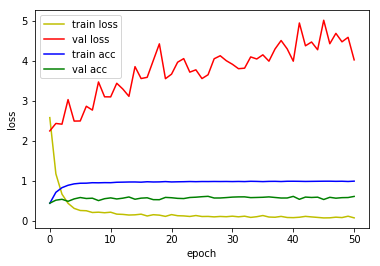

4815/4815 [==============================] - 3s 608us/sample - loss: 2.2996 - acc: 0.4289
Loss: 2.2996431459890347 Accuracy: 0.42886811

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8067 - acc: 0.4923
Epoch 00001: val_loss improved from inf to 1.72821, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_BN_4_conv_checkpoint/001-1.7282.hdf5
36805/36805 [==============================] - 58s 2ms/sample - loss: 1.8066 - acc: 0.4924 - val_loss: 1.7282 - val_acc: 0.4873
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0115 - acc: 0.7015
Epoch 00002: val_loss improved from 1.72821 to 1.40755, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_BN_4_conv_checkpoint/002-1.4075.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 1.0115 - acc: 0.7015 - val_loss: 1.4075 - val_acc: 0.6110
Epoch 3/500
36800/36805 [============================>.] - E

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0443 - acc: 0.9910
Epoch 00029: val_loss did not improve from 1.24245
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.0443 - acc: 0.9910 - val_loss: 2.1334 - val_acc: 0.6497
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0440 - acc: 0.9915
Epoch 00030: val_loss did not improve from 1.24245
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.0443 - acc: 0.9915 - val_loss: 2.0172 - val_acc: 0.6643
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0533 - acc: 0.9873
Epoch 00031: val_loss did not improve from 1.24245
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.0533 - acc: 0.9873 - val_loss: 1.9394 - val_acc: 0.6774
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0371 - acc: 0.9922
Epoch 00032: val_loss did not improve from 1.24245
36805/36805 [===========

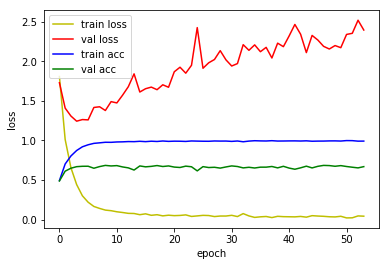

4815/4815 [==============================] - 3s 628us/sample - loss: 1.3310 - acc: 0.6368
Loss: 1.3310384488427627 Accuracy: 0.6367601

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6366 - acc: 0.5101
Epoch 00001: val_loss improved from inf to 1.52557, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_BN_5_conv_checkpoint/001-1.5256.hdf5
36805/36805 [==============================] - 62s 2ms/sample - loss: 1.6370 - acc: 0.5100 - val_loss: 1.5256 - val_acc: 0.5399
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0289 - acc: 0.6939
Epoch 00002: val_loss improved from 1.52557 to 1.14110, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_BN_5_conv_checkpoint/002-1.1411.hdf5
36805/36805 [==============================] - 55s 2ms/sample - loss: 1.0290 - acc: 0.6938 - val_loss: 1.1411 - val_acc: 0.6758
Epoch 3/500
36800/36805 [============================>.] - ET

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0389 - acc: 0.9937
Epoch 00027: val_loss did not improve from 0.74435
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0389 - acc: 0.9938 - val_loss: 0.8902 - val_acc: 0.8099
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0402 - acc: 0.9926
Epoch 00028: val_loss did not improve from 0.74435
36805/36805 [==============================] - 55s 2ms/sample - loss: 0.0402 - acc: 0.9926 - val_loss: 0.8722 - val_acc: 0.8092
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0443 - acc: 0.9912
Epoch 00029: val_loss did not improve from 0.74435
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0445 - acc: 0.9911 - val_loss: 1.2669 - val_acc: 0.7391
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0594 - acc: 0.9851
Epoch 00030: val_loss did not improve from 0.74435
36805/36805 [===========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0189 - acc: 0.9970
Epoch 00057: val_loss did not improve from 0.74435
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0189 - acc: 0.9970 - val_loss: 1.0064 - val_acc: 0.8118
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0250 - acc: 0.9948
Epoch 00058: val_loss did not improve from 0.74435
36805/36805 [==============================] - 55s 1ms/sample - loss: 0.0253 - acc: 0.9947 - val_loss: 1.0830 - val_acc: 0.8043
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0454 - acc: 0.9894
Epoch 00059: val_loss did not improve from 0.74435
36805/36805 [==============================] - 55s 2ms/sample - loss: 0.0454 - acc: 0.9894 - val_loss: 0.9037 - val_acc: 0.8237
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0188 - acc: 0.9972
Epoch 00060: val_loss did not improve from 0.74435
36805/36805 [===========

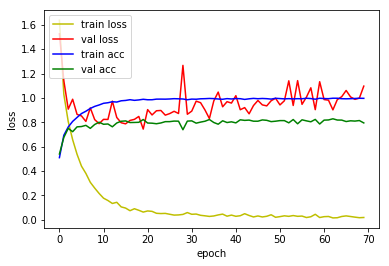

4815/4815 [==============================] - 3s 646us/sample - loss: 0.8024 - acc: 0.7994
Loss: 0.8024348169719938 Accuracy: 0.79937696

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6082 - acc: 0.5063
Epoch 00001: val_loss improved from inf to 1.28036, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_BN_6_conv_checkpoint/001-1.2804.hdf5
36805/36805 [==============================] - 66s 2ms/sample - loss: 1.6081 - acc: 0.5063 - val_loss: 1.2804 - val_acc: 0.5926
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9375 - acc: 0.7218
Epoch 00002: val_loss improved from 1.28036 to 0.88036, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_BN_6_conv_checkpoint/002-0.8804.hdf5
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.9378 - acc: 0.7217 - val_loss: 0.8804 - val_acc: 0.7338
Epoch 3/500
36800/36805 [============================>.] - E

36800/36805 [============================>.] - ETA: 0s - loss: 0.0342 - acc: 0.9941
Epoch 00026: val_loss did not improve from 0.36326
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0342 - acc: 0.9941 - val_loss: 0.4268 - val_acc: 0.8861
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0437 - acc: 0.9909
Epoch 00027: val_loss did not improve from 0.36326
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0437 - acc: 0.9909 - val_loss: 0.5383 - val_acc: 0.8623
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0356 - acc: 0.9934
Epoch 00028: val_loss did not improve from 0.36326
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0356 - acc: 0.9934 - val_loss: 0.4326 - val_acc: 0.8938
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0378 - acc: 0.9919
Epoch 00029: val_loss did not improve from 0.36326
36805/36805 [========================

Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0113 - acc: 0.9982
Epoch 00056: val_loss did not improve from 0.36326
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0114 - acc: 0.9982 - val_loss: 0.4188 - val_acc: 0.9078
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0133 - acc: 0.9973
Epoch 00057: val_loss did not improve from 0.36326
36805/36805 [==============================] - 56s 2ms/sample - loss: 0.0136 - acc: 0.9973 - val_loss: 0.4191 - val_acc: 0.9136
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0204 - acc: 0.9950
Epoch 00058: val_loss did not improve from 0.36326
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0205 - acc: 0.9950 - val_loss: 0.4128 - val_acc: 0.9061
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0237 - acc: 0.9943
Epoch 00059: val_loss did not improve from 0.36326
36805/36805 [===========

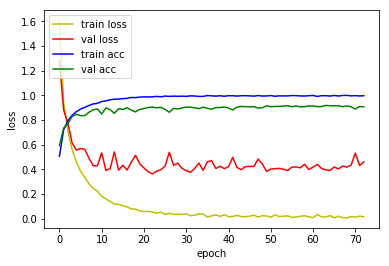

4815/4815 [==============================] - 3s 686us/sample - loss: 0.4072 - acc: 0.8889
Loss: 0.40719286103114904 Accuracy: 0.8888889

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5850 - acc: 0.5192
Epoch 00001: val_loss improved from inf to 1.24229, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_BN_7_conv_checkpoint/001-1.2423.hdf5
36805/36805 [==============================] - 68s 2ms/sample - loss: 1.5849 - acc: 0.5193 - val_loss: 1.2423 - val_acc: 0.6145
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.7901 - acc: 0.7698
Epoch 00002: val_loss improved from 1.24229 to 0.65981, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_BN_7_conv_checkpoint/002-0.6598.hdf5
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.7905 - acc: 0.7697 - val_loss: 0.6598 - val_acc: 0.8004
Epoch 3/500
36800/36805 [============================>.] - E

36800/36805 [============================>.] - ETA: 0s - loss: 0.0272 - acc: 0.9943
Epoch 00025: val_loss did not improve from 0.21068
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0272 - acc: 0.9943 - val_loss: 0.2298 - val_acc: 0.9394
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0299 - acc: 0.9932
Epoch 00026: val_loss did not improve from 0.21068
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0298 - acc: 0.9932 - val_loss: 0.2171 - val_acc: 0.9380
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0224 - acc: 0.9956
Epoch 00027: val_loss did not improve from 0.21068
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0225 - acc: 0.9955 - val_loss: 0.2398 - val_acc: 0.9371
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0324 - acc: 0.9921
Epoch 00028: val_loss did not improve from 0.21068
36805/36805 [========================

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0111 - acc: 0.9975
Epoch 00054: val_loss did not improve from 0.20115
36805/36805 [==============================] - 59s 2ms/sample - loss: 0.0111 - acc: 0.9975 - val_loss: 0.2421 - val_acc: 0.9392
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0076 - acc: 0.9986
Epoch 00055: val_loss did not improve from 0.20115
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0076 - acc: 0.9986 - val_loss: 0.2356 - val_acc: 0.9453
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0089 - acc: 0.9982
Epoch 00056: val_loss did not improve from 0.20115
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0089 - acc: 0.9982 - val_loss: 0.2316 - val_acc: 0.9446
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0105 - acc: 0.9974
Epoch 00057: val_loss did not improve from 0.20115
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0143 - acc: 0.9961
Epoch 00083: val_loss did not improve from 0.19738
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0145 - acc: 0.9961 - val_loss: 0.2802 - val_acc: 0.9371
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0191 - acc: 0.9944
Epoch 00084: val_loss did not improve from 0.19738
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0193 - acc: 0.9943 - val_loss: 0.2063 - val_acc: 0.9541
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0116 - acc: 0.9973
Epoch 00085: val_loss did not improve from 0.19738
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0116 - acc: 0.9973 - val_loss: 0.2090 - val_acc: 0.9548
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0037 - acc: 0.9995
Epoch 00086: val_loss did not improve from 0.19738
36805/36805 [========================

Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0172 - acc: 0.9951
Epoch 00113: val_loss did not improve from 0.19738
36805/36805 [==============================] - 59s 2ms/sample - loss: 0.0172 - acc: 0.9951 - val_loss: 0.2188 - val_acc: 0.9534
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0025 - acc: 0.9995
Epoch 00114: val_loss did not improve from 0.19738
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0025 - acc: 0.9995 - val_loss: 0.2339 - val_acc: 0.9525
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0063 - acc: 0.9985
Epoch 00115: val_loss did not improve from 0.19738
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0063 - acc: 0.9985 - val_loss: 0.2197 - val_acc: 0.9539
Epoch 116/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0046 - acc: 0.9989
Epoch 00116: val_loss did not improve from 0.19738
36805/36805 [=======

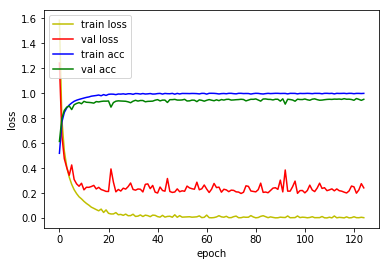

4815/4815 [==============================] - 3s 724us/sample - loss: 0.2588 - acc: 0.9389
Loss: 0.25881171178455664 Accuracy: 0.9389408

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3659 - acc: 0.5829
Epoch 00001: val_loss improved from inf to 0.98348, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_BN_8_conv_checkpoint/001-0.9835.hdf5
36805/36805 [==============================] - 74s 2ms/sample - loss: 1.3658 - acc: 0.5829 - val_loss: 0.9835 - val_acc: 0.7142
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5618 - acc: 0.8350
Epoch 00002: val_loss improved from 0.98348 to 0.40348, saving model to model/checkpoint/1D_CNN_custom_multi_2_concat_BN_8_conv_checkpoint/002-0.4035.hdf5
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.5617 - acc: 0.8350 - val_loss: 0.4035 - val_acc: 0.8856
Epoch 3/500
36800/36805 [============================>.] - E

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0171 - acc: 0.9966
Epoch 00027: val_loss did not improve from 0.16415
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0171 - acc: 0.9966 - val_loss: 0.1682 - val_acc: 0.9546
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0104 - acc: 0.9984
Epoch 00028: val_loss did not improve from 0.16415
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0104 - acc: 0.9984 - val_loss: 0.1857 - val_acc: 0.9539
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0128 - acc: 0.9976
Epoch 00029: val_loss did not improve from 0.16415
36805/36805 [==============================] - 57s 2ms/sample - loss: 0.0128 - acc: 0.9976 - val_loss: 0.2012 - val_acc: 0.9478
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0140 - acc: 0.9974
Epoch 00030: val_loss did not improve from 0.16415
36805/36805 [===========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0143 - acc: 0.9954
Epoch 00057: val_loss did not improve from 0.16415
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0143 - acc: 0.9954 - val_loss: 0.1915 - val_acc: 0.9555
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0037 - acc: 0.9994
Epoch 00058: val_loss did not improve from 0.16415
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0037 - acc: 0.9994 - val_loss: 0.1956 - val_acc: 0.9546
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0023 - acc: 0.9998
Epoch 00059: val_loss did not improve from 0.16415
36805/36805 [==============================] - 58s 2ms/sample - loss: 0.0023 - acc: 0.9998 - val_loss: 0.1858 - val_acc: 0.9602
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0111 - acc: 0.9967
Epoch 00060: val_loss did not improve from 0.16415
36805/36805 [===========

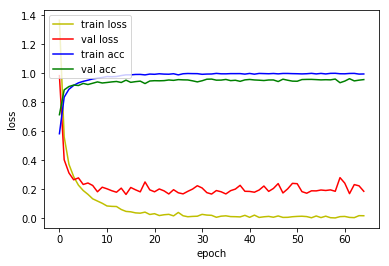

4815/4815 [==============================] - 3s 717us/sample - loss: 0.2275 - acc: 0.9288
Loss: 0.22747659368802206 Accuracy: 0.9287643



In [10]:
base = '1D_CNN_custom_multi_2_concat_BN'

for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    model = build_cnn(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_multi_2_concat_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 9):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_2_concat_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 64)    384         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_39 (Batc (None, 16000, 64)    256         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 64)    0           batch_normalization_v1_39[0][0]  
_______________________________________________________________

4815/4815 [==============================] - 3s 699us/sample - loss: 1.3310 - acc: 0.6368
Loss: 1.3310384488427627 Accuracy: 0.6367601

1D_CNN_custom_multi_2_concat_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 64)    384         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_48 (Batc (None, 16000, 64)    256         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activation) 

4815/4815 [==============================] - 4s 761us/sample - loss: 0.4072 - acc: 0.8889
Loss: 0.40719286103114904 Accuracy: 0.8888889

1D_CNN_custom_multi_2_concat_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 64)    384         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_61 (Batc (None, 16000, 64)    256         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activation)

4815/4815 [==============================] - 4s 799us/sample - loss: 0.2275 - acc: 0.9288
Loss: 0.22747659368802206 Accuracy: 0.9287643


In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_BN_2'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 9):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_multi_2_concat_BN_3_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 16000, 64)    384         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_39 (Batc (None, 16000, 64)    256         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16000, 64)    0           batch_normalization_v1_39[0][0]  
_______________________________________________________________

4815/4815 [==============================] - 4s 840us/sample - loss: 2.6378 - acc: 0.6368
Loss: 2.6378005140171865 Accuracy: 0.6367601

1D_CNN_custom_multi_2_concat_BN_5_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_40 (Conv1D)              (None, 16000, 64)    384         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_48 (Batc (None, 16000, 64)    256         conv1d_40[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activation) 

4815/4815 [==============================] - 4s 838us/sample - loss: 0.4866 - acc: 0.8964
Loss: 0.48655820212647055 Accuracy: 0.8963655

1D_CNN_custom_multi_2_concat_BN_7_conv Model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 16000, 1)     0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 16000, 64)    384         input_11[0][0]                   
__________________________________________________________________________________________________
batch_normalization_v1_61 (Batc (None, 16000, 64)    256         conv1d_51[0][0]                  
__________________________________________________________________________________________________
activation_51 (Activation)

4815/4815 [==============================] - 5s 956us/sample - loss: 0.2415 - acc: 0.9406
Loss: 0.2414763518275455 Accuracy: 0.9406023
